In [1]:
import os
import caesar
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import modules as anal
import modules.anal_func as anal_func

from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.io import fits
from scipy import interpolate
from unyt import Unit

from modules.anal_func.filter_particles import copy_skeleton, filter_particles_by_obj, filter_by_aperture
from modules.anal_func.build_history import BuildHistory


cosmo = LambdaCDM(H0 = 68, Om0= 0.3, Ode0= 0.7, Ob0=0.048)
plt.rcParams.update({'font.size': 28})

In [3]:
# initialize the Simba class, which import the needed paths
sb = anal.Simba('cis', size='50_full') #always keep track of the size of the simulation!!!!!!
z = sb.get_redshifts()
clust_mass_thresh = 1e12
cs = sb.get_caesar(90)

yt : [INFO     ] 2024-08-29 18:20:57,317 Opening /mnt/home/glorenzon/SIMBA_catalogs/simba50_snaps/full//Groups/m50n512_090.hdf5
yt : [INFO     ] 2024-08-29 18:20:57,418 Found 68131 halos
yt : [INFO     ] 2024-08-29 18:20:57,470 Found 4345 galaxies


In [4]:
# We want all central galaxies in clusters
central_gal_ind = np.asarray([i.GroupID for i in cs.galaxies if i.central==1]) # select central galaxies
print('Total number of central galaxies: ', len(central_gal_ind))
gals_in_clusters = [i.galaxy_index_list for i in cs.halos if i.masses['total']>clust_mass_thresh] # galaxies in masive halos
gals_in_clusters = np.concatenate(gals_in_clusters)
print(f'Total number of Mtot above {clust_mass_thresh} Msun: ', len(gals_in_clusters))
central_in_cluster_id = central_gal_ind[np.isin(central_gal_ind, gals_in_clusters)]
print('Total number of central galaxies in clusters: ', len(central_in_cluster_id))

Total number of central galaxies:  3147
Total number of Mtot above 1000000000000.0 Msun:  1431
Total number of central galaxies in clusters:  506


In [5]:
from modules.anal_func.read_progenitors import read_progen
from modules.data_objects.convert_hdf5_fits import *
local_snaps = [44, 79, 105, 124, 145]
#convert_hdf5_fits(sb, local_snaps, ignore=['mag', 'start', 'end', 'list'], only=[], verbose=0, overwrite=True)
#read_progen(central_in_cluster_id, 'progenitors_cluster_central_m25.fits', local_snaps, sb, fitsdir='/home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/')

Processing : /media/lorenzong/Data1/simba_hig_res/m25n512_149.hdf5
Saved fits in: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m25n512_149.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m25n512_149.fits


KeyError: "Key 'descend_galaxy_star' does not exist."

In [ ]:
sfh = BuildHistory(sb, '/home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5', progfilename='progenitors_most_mass_nocaesar.fits')
# here we have all the indexes 
# take the ids we want
sfh.get_history_indx(central_in_cluster_id, start_snap=44, end_snap=149) 
# we just need the galaxy GroupID and the nsapshots
id_history = sfh.get_property_history(['GroupID'])


for i in local_snaps:
    filter_particles_by_obj(cs=cs,\
                            simfile=sb.get_sim_file(i),\
                            snap=i, selection='galaxy',\
                            oidx=central_in_cluster_id, verbose=0, overwrite=True, ignore_fields=[], keyword=None)

In [ ]:
# now we write something to select the galaxies in specific points in hystory
# initialize the class for the galaxy hystory
sfh = BuildHistory(sb, '/home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5', progfilename='progenitors_most_mass_nocaesar.fits')
# here we have all the indexes 
cs = sb.get_caesar(150)
totids = np.asarray([i.GroupID for i in cs.galaxies])
# take the ids we want
sfh.get_history_indx(totids[:1000], start_snap=44, end_snap=149) 
# we just need the galaxy GroupID and the nsapshots
id_history = sfh.get_property_history(['GroupID'])

paths = anal.SavePaths()
output_dir = paths.get_filetype_path('txt')
output_dir = paths.create_subdir(output_dir, 'targets_history')
most_massive_history = id_history['GroupID'][0,:]
most_massive_history = np.column_stack((range(44, 150), id_history['GroupID'][:,0]))
np.savetxt(os.path.join(output_dir, 'history_most_massive.txt'), most_massive_history, fmt='%d')


In [6]:
import yt
from unyt import unyt_array

# Load the simulation dataset
ds = yt.load(sb.get_sim_file(129))

# Define a value in Kpc
kpc_value = 1.0  # Example value in Kpc

# Convert from Kpc to simulation's length unit ('kpc/h' as given in your metadata)
# If 'code_length' is not directly available, use the known conversion factor from the dataset
kpc_quantity = ds.quan(kpc_value, 'kpc')

# Convert to code_length (assumed to be the same as 'kpc' but need verification)
code_length_quantity = kpc_quantity.to('code_length', equivalency='length')

yt : [INFO     ] 2024-08-27 10:38:53,734 Calculating time from 7.114e-01 to be 2.969e+17 seconds
yt : [INFO     ] 2024-08-27 10:38:53,735 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2024-08-27 10:38:53,754 Parameters: current_time              = 2.968791388457766e+17 s
yt : [INFO     ] 2024-08-27 10:38:53,755 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-08-27 10:38:53,755 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-08-27 10:38:53,755 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2024-08-27 10:38:53,756 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-08-27 10:38:53,756 Parameters: current_redshift          = 0.4057579856290421
yt : [INFO     ] 2024-08-27 10:38:53,756 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2024-08-27 10:38:53,756 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2024-08-27 10:38:53,756 Parameters: omega_radiation     

In [8]:
kpc_quantity
code_length_quantity

unyt_quantity(0.95591543, 'code_length')

In [6]:
snap=90
cs = sb.get_caesar(snap)
pos = [i.pos.in_units('code_length') for i in cs.galaxies]
import time
start = time.time()
filter_by_aperture(cs=cs,\
                        simfile=sb.get_sim_file(snap),\
                        snap=snap, 
                        center= pos[0].value,\
                        radius=100,\
                        selection='galaxy',\
                        verbose=1, overwrite=True, ignore_fields=[], keyword=None, closegal=0)
end = time.time()
print(end-start)

yt : [INFO     ] 2024-08-29 18:22:19,279 Opening /mnt/home/glorenzon/SIMBA_catalogs/simba50_snaps/full//Groups/m50n512_090.hdf5
yt : [INFO     ] 2024-08-29 18:22:19,354 Found 68131 halos
yt : [INFO     ] 2024-08-29 18:22:19,407 Found 4345 galaxies


Analizing particle file /mnt/home/glorenzon/SIMBA_catalogs/simba50_snaps/full/snap_m50n512_090.hdf5
Start copy the file structure
Finish copy the file structure
Selecting particles for : PartType0
Using an aperture of 100 Kpc ---> 249.6691905583613 cKpc centered at [24194.74796875 33212.0446875  37036.18671875]
Found single radius
PartType0 AGS-Softening
PartType0 Coordinates
PartType0 DelayTime
PartType0 Density
PartType0 Dust_Masses
PartType0 Dust_Metallicity
PartType0 ElectronAbundance
PartType0 FractionH2
PartType0 GrackleHI
PartType0 GrackleHII
PartType0 GrackleHM
PartType0 GrackleHeI
PartType0 GrackleHeII
PartType0 GrackleHeIII
PartType0 HaloID
PartType0 ID_Generations
PartType0 InternalEnergy
PartType0 Masses
PartType0 Metallicity
PartType0 NWindLaunches
PartType0 NeutralHydrogenAbundance
PartType0 ParticleIDs
PartType0 Potential
PartType0 Sigma
PartType0 SmoothingLength
PartType0 StarFormationRate
PartType0 Velocities
Updated Header: {'BoxSize': 50000.0, 'Flag_Cooling': 1, 'Fla

In [7]:
print((end-start)/60)

1.4966556310653687


In [ ]:
cs.simulation.boxsize.value

In [8]:
a = np.array([0,2,3])
print(a.shape)

(3,)


In [4]:
gid = [i.GroupID for i in cs.galaxies][100]

In [3]:
pos[10].value

NameError: name 'pos' is not defined

In [8]:
m = [i.masses['stellar'] for i in cs.galaxies][100]

In [9]:
[i.sfr for i in cs.galaxies][100]

unyt_quantity(0.27865422, 'Msun/yr')

In [8]:
part = '/media/lorenzong/Data1/simba_hig_res/snap_m25n512_129.hdf5'
import h5py
with h5py.File(part) as p:
    print(p['PartType1']['Coordinates'][:,0].max())



24999.998


In [4]:
pos = np.asarray([i.pos for i in cs.galaxies])
pos[:,0].max()

36763.016

In [5]:
b = np.asarray([i.masses['gas'] for i in cs.galaxies])

In [6]:
np.where(b==b.max())[0]

array([10])

In [9]:
pos[5000,0]

TypeError: list indices must be integers or slices, not tuple

In [15]:
s = []
for i in pos:
    s.append(sum(i))
s = np.asarray(s)
print(np.where(s==s.min())[0])

[2220]


In [16]:
pos[2220]

unyt_array([3391.33325195, 5057.37011719,  763.19250488], dtype=float32, units='kpccm')

yt : [INFO     ] 2024-08-23 11:53:20,825 Opening /media/lorenzong/Data1/simba_hig_res/m25n512_129.hdf5
yt : [INFO     ] 2024-08-23 11:53:20,836 Found 263961 halos
yt : [INFO     ] 2024-08-23 11:53:20,840 Found 5290 galaxies


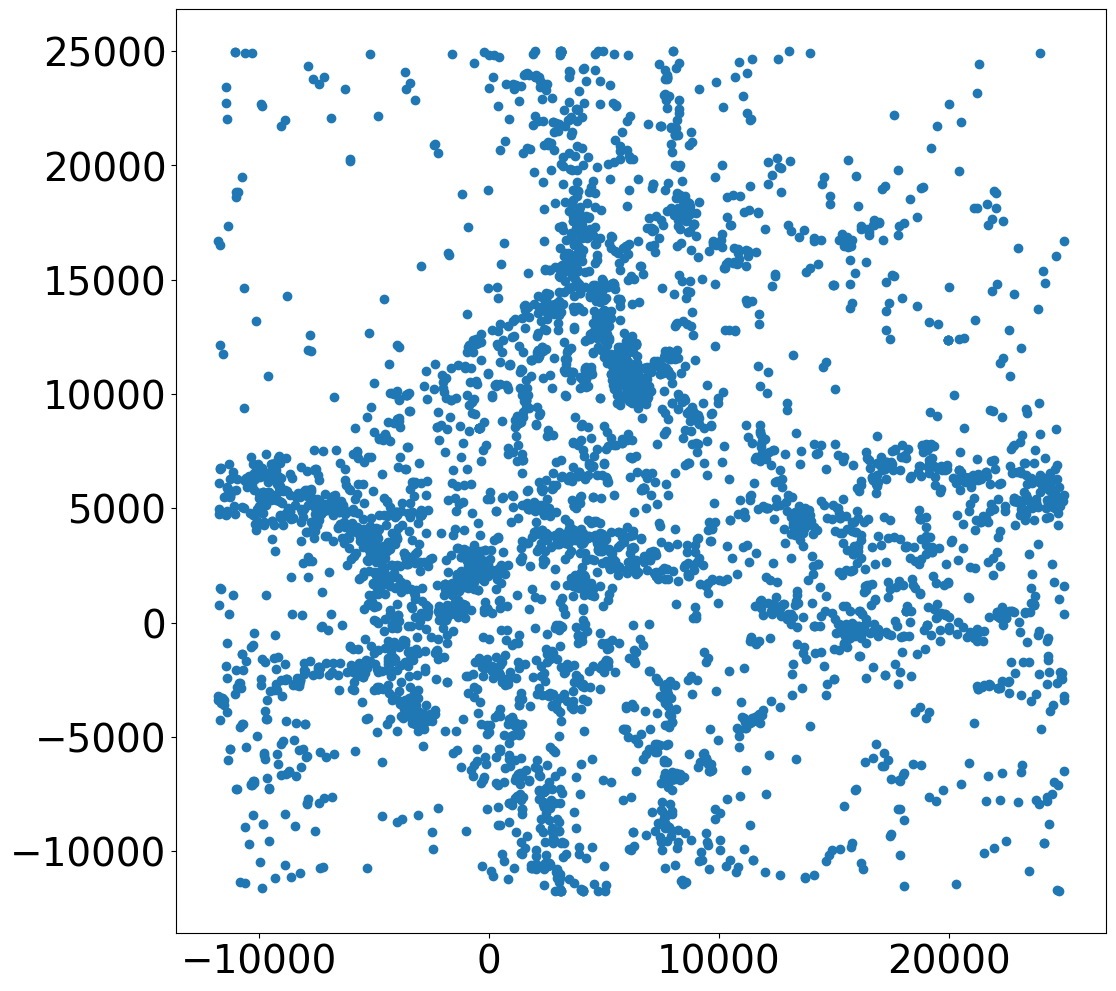

In [22]:
# initialize the Simba class, which import the needed paths
sb = anal.Simba('PC39BP4', size=25) #always keep track of the size of the simulation!!!!!!
cs = sb.get_caesar(129)
plt.figure(figsize=(12,12))
delta = np.asarray([i.pos[0] for i in cs.galaxies]).max() - 25000
x = np.asarray([i.pos[0] for i in cs.galaxies]) - delta
y = np.asarray([i.pos[1] for i in cs.galaxies]) - delta
z = np.asarray([i.pos[2] for i in cs.galaxies]) - delta
plt.scatter(x, y)

In [7]:
np.asarray([i.pos for i in cs.galaxies])[2220]

array([3391.3333, 5057.37  ,  763.1925], dtype=float32)

In [9]:
np.asarray([i.pos.in_units('code_length') for i in cs.galaxies])[2220]

array([2306.1067, 3439.0117,  518.9709], dtype=float32)

In [8]:
import h5py
import caesar
import sys
import glob
import numpy as np
import tqdm
import os

###########
# Line arguments
###########
snapshot_path = '/media/lorenzong/Data1/simba_hig_res/snap_m25n512_'
snap_num = 129
output_path = '/home/lorenzong/analize_simba_cgm/output/hdf5/filtered_part_files/snap'+str(snap_num).zfill(3)
caesar_file = '/media/lorenzong/Data1/simba_hig_res/m25n512_129.hdf5'

#see if the output path exists, and if not, make it

if not os.path.exists(output_path):
      os.makedirs(output_path)
      print("creating output directory: "+output_path)


obj = caesar.load(caesar_file)
snap_str = str(snap_num).zfill(3)

input_file = h5py.File(snapshot_path+str(snap_str)+'.hdf5', 'r')


galcount = len(obj.galaxies)
for galaxy in range(galcount):
      print()
      print("GALAXY NUM:",str(galaxy))
      print()
      glist = obj.galaxies[int(galaxy)].glist
      slist = obj.galaxies[int(galaxy)].slist


      with h5py.File(output_path+'galaxy_'+str(galaxy)+'.hdf5', 'w') as output_file:
          output_file.copy(input_file['Header'], 'Header')
          print('starting with gas attributes now')
          output_file.create_group('PartType0')
          for k in tqdm.tqdm(input_file['PartType0']):
              output_file['PartType0'][k] = input_file['PartType0'][k][:][glist]
          print('moving to star attributes now')
          output_file.create_group('PartType4')
          for k in tqdm.tqdm(input_file['PartType4']):
              output_file['PartType4'][k] = input_file['PartType4'][k][:][slist]


      print('done copying attributes, going to edit header now')
      outfile_reload = output_path+'galaxy_'+str(galaxy)+'.hdf5'

      re_out = h5py.File(outfile_reload,'r+')
      re_out['Header'].attrs.modify('NumPart_ThisFile', np.array([len(glist), 0, 0, 0, len(slist), 0]))
      re_out['Header'].attrs.modify('NumPart_Total', np.array([len(glist), 0, 0, 0, len(slist), 0]))

      re_out.close()

yt : [INFO     ] 2024-08-23 20:24:34,623 Opening /media/lorenzong/Data1/simba_hig_res/m25n512_129.hdf5
yt : [INFO     ] 2024-08-23 20:24:34,627 Found 263961 halos
yt : [INFO     ] 2024-08-23 20:24:34,630 Found 5290 galaxies



GALAXY NUM: 0

starting with gas attributes now


100%|███████████████████████████████████████████████████████████████| 27/27 [02:15<00:00,  5.03s/it]


moving to star attributes now


100%|███████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.44it/s]


done copying attributes, going to edit header now

GALAXY NUM: 1

starting with gas attributes now


100%|███████████████████████████████████████████████████████████████| 27/27 [02:19<00:00,  5.15s/it]


moving to star attributes now


100%|███████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.84it/s]


done copying attributes, going to edit header now

GALAXY NUM: 2

starting with gas attributes now


 19%|███████████▊                                                    | 5/27 [00:43<03:10,  8.66s/it]


KeyboardInterrupt: 